In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import datetime

In [2]:
mypath = r"Stats"
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

onlyfiles = [f for f in onlyfiles if "tuiew" in f]
print(onlyfiles)

['tuiew_Profile0_22_10_07__18_46.csv', 'tuiew_Profile0_22_10_09__00_34.csv', 'tuiew_Profile0_22_10_09__02_48.csv', 'tuiew_Profile0_22_10_09__02_53.csv', 'tuiew_Profile0_22_10_09__21_27.csv', 'tuiew_Profile1_22_10_09__21_27.csv', 'tuiew_Profile5_22_10_07__18_21.csv']


In [20]:
#df = pd.read_csv(os.path.join(mypath, onlyfiles[0]))

def condenseStats(file):
    df = pd.read_csv(os.path.join(mypath, file))
    #preprocess gametime
    
    t = np.array(df["Time"], )
    t = t.astype(datetime)

    t = np.array([datetime.strptime(my_date_string, '%Y-%m-%d %H:%M:%S.%f') for my_date_string in t])

    start_time = t[0]
    t = t - start_time

    t = np.array([int(timesince.total_seconds()) for timesince in t]) 
    df["GameTime"] = t
    
    time_played = t[-1]
    time_played_min = time_played / 60
    
    print(f"time played {time_played} seconds. {time_played_min} minutes")
    
    print("\nplayer damaging enemies")
    events= ("killed an enemy", "enemy_headshot")

    for e in events:
        df_event = df.loc[df["Event"]==e]
        print(e, len(df_event), "  |  ", len(df_event)/time_played_min, " per minute")
        
    df_event = df.loc[df["Event"].str.contains("weapon_fired", case = False)]
    print("weapon_fired", len(df_event), "  |  ", len(df_event)/time_played_min)
    l = np.array(df_event["Event"])
    l = np.array([st.split(" ")[-1] for st in l], int).astype(int)
    print("hits",l.sum(),  "  |  ", l.sum()/time_played_min, " per minute")
    print("accuracy is ", l.sum()/len(df_event))
    
    
    print("\nplayer taking damage")
    
    events= ("shielded hit", "unshielded hit", "tased", "auto regenerate armor", "auto replenish health", "downed", "revived by ally")
    for e in events:
        df_event = df.loc[df["Event"]==e]
        print(e, len(df_event),  "  |  ", len(df_event)/time_played_min, " per minute")
    
    
    eventContains = ("complete_objective", "activate_objective")
    for e in eventContains:
        df_event = df.loc[df["Event"].str.contains(e, case = False)]
        print(e, len(df_event), "  |  ", len(df_event)/time_played_min, " per minute")
        
    # average hp value
    
    df_hp = df.loc[df["Event"].str.contains("hp", case = False)]
    hp = np.array([int(ev.replace("hp ","")) for ev in df_hp["Event"]])
    hp_max = np.max(hp)
    #hp = hp/hp_max

    print(f"Average Hp is {np.average(hp)}")
    # player armor
    df_armor = df.loc[df["Event"].str.contains("armor", case = False)]
    df_armor = df_armor.loc[~df_armor["Event"].str.contains("regenerate armor", case = False)]
    armor = np.array([int(ev.replace("armor ","")) for ev in df_armor["Event"]])
    armor_max = np.max(armor)
    #armor = armor/armor_max
    
    print(f"Average Armor is {np.average(armor)}")
    
    # total health lost
    
    def total_value_lost(li):
        peak = li[0]
        valley = li[0]
        last = li[0]
        climbing = True
        
        lost = 0
        
        for val in li:
            #print(val)
            if climbing:
                if last <= val: # going up
                    peak = val # finding value of peak
                else: #last >= val going down
                    valley = val 
                    climbing = False
                    # we switch direction. peak found
            else:
                if last >= val:
                    valley = val # finding value of valley
                else:
                    # found a valley. next climb again
                    lost = lost + (peak - valley)
                    #print(f"found valley peak: {peak} valley: {valley}. total now: {lost}")
                    peak = val
                    climbing = True
            last = val
        return lost
            
    #print(f"total hp lost {total_value_lost(hp)}   |    {total_value_lost(hp)/time_played_min}")
    print(f"total armor lost {total_value_lost(armor)}    |     {total_value_lost(armor)/time_played_min} per minute")
    
    #fig, ax=plt.subplots(figsize=(15,10))
    #ax.plot(df_hp["GameTime"], hp, label="hp", linewidth=4.0, color='orange')
    
    hp_lost = df.loc[df["Event"].str.contains("health_subtracted", case = False)]
    hp_lost = np.array([float(ev.replace("health_subtracted ","")) for ev in hp_lost["Event"]])
    print(f"total hp lost {int(np.sum(hp_lost)*10)}     |     {int(np.sum(hp_lost)*10) / time_played_min} per minute")
    
    # how much time spend on full armor?
    
    armor_time = np.array(df_armor["GameTime"])
    
    def time_spent_at_max_value(values, time, max_value, starts_with_interval):
        #print(f"\nfinding time spend at max value {max_value}")
        interval_start = 0
        end_time = 0
        is_max_val = starts_with_interval
        total_max_val_time = 0
        interval_entries= 0
        for val, t in zip(values,time):
            #print(f"{t} : {val}")
            if is_max_val:
                if val == max_value:
                    end_time = t
                    #print(f"{t} is max, extending interval")
                else:
                    total_max_val_time = total_max_val_time + ( end_time - interval_start )
                    #print(f"{t} end of interval found. {end_time} - {interval_start}")
                    interval_start = t
                    end_time = t
                    is_max_val = False
            else:
                if val == max_value:
                    #print(f"{t} starting interval {val}")
                    interval_start = t
                    end_time = t
                    is_max_val = True
                    interval_entries = interval_entries + 1
                #else:
                    #print(f"{t} is not max, no interval")
        #print(f"interval_entires {interval_entries}")
        return total_max_val_time
                    
    total_max_armor_time = time_spent_at_max_value(armor, armor_time, armor_max, True)        
    print(f"time spend with max armor : {total_max_armor_time}    |      {(total_max_armor_time / time_played)* 100} % of the game")
    
    # time spent crouching
    df_crouching = df.loc[df["Event"].str.contains("stance_crouched", case = False)]
    crouching = np.array([int (ev.replace("stance_crouched ","")) for ev in df_crouching["Event"]])
    crouching_time = np.array(df_crouching["GameTime"])
    total_crouching_time = time_spent_at_max_value(crouching, crouching_time, 1, False)
    print(f"time spend crouched: {total_crouching_time}      |     {(total_crouching_time / time_played) * 100} % of the game")


condenseStats("tuiew_Profile0_22_10_09__21_27.csv")

time played 38 seconds. 0.6333333333333333 minutes

player damaging enemies
killed an enemy 2   |   3.1578947368421053  per minute
enemy_headshot 1   |   1.5789473684210527  per minute
weapon_fired 19   |   30.0
hits 4   |   6.315789473684211  per minute
accuracy is  0.21052631578947367

player taking damage
shielded hit 12   |   18.947368421052634  per minute
unshielded hit 0   |   0.0  per minute
tased 0   |   0.0  per minute
auto regenerate armor 1   |   1.5789473684210527  per minute
auto replenish health 0   |   0.0  per minute
downed 0   |   0.0  per minute
revived by ally 0   |   0.0  per minute
complete_objective 1   |   1.5789473684210527  per minute
activate_objective 2   |   3.1578947368421053  per minute
Average Hp is 460.0
Average Armor is 156.28947368421052
total armor lost 116    |     183.1578947368421 per minute
total hp lost 0     |     0.0 per minute
time spend with max armor : 13    |      34.21052631578947 % of the game
time spend crouched: 10      |     26.3157894

In [21]:
condenseStats("tuiew_Profile5_22_10_07__18_21.csv")

time played 1378 seconds. 22.966666666666665 minutes

player damaging enemies
killed an enemy 374   |   16.284470246734397  per minute
enemy_headshot 78   |   3.3962264150943398  per minute
weapon_fired 2213   |   96.35703918722787
hits 592   |   25.77648766328012  per minute
accuracy is  0.2675101671938545

player taking damage
shielded hit 221   |   9.622641509433963  per minute
unshielded hit 7   |   0.30478955007256897  per minute
tased 2   |   0.08708272859216257  per minute
auto regenerate armor 107   |   4.658925979680697  per minute
auto replenish health 0   |   0.0  per minute
downed 1   |   0.043541364296081284  per minute
revived by ally 1   |   0.043541364296081284  per minute
complete_objective 19   |   0.8272859216255444  per minute
activate_objective 20   |   0.8708272859216256  per minute
Average Hp is 136.7595459236326
Average Armor is 193.640350877193
total armor lost 4340    |     188.96952104499275 per minute
total hp lost 146     |     6.357039187227867 per minute


In [14]:
condenseStats("tuiew_Profile0_22_10_07__18_46.csv")

time played 1142 seconds. 19.033333333333335 minutes

player damaging enemies
killed an enemy 327   |   17.180385288966722  per minute
enemy_headshot 107   |   5.621716287215411  per minute
weapon_fired 2292   |   120.42031523642731
hits 502   |   26.37478108581436  per minute
accuracy is  0.21902268760907503

player taking damage
shielded hit 258   |   13.555166374781084  per minute
unshielded hit 10   |   0.5253940455341506  per minute
tased 0   |   0.0  per minute
auto regenerate armor 107   |   5.621716287215411  per minute
auto replenish health 0   |   0.0  per minute
downed 1   |   0.052539404553415055  per minute
revived by ally 1   |   0.052539404553415055  per minute
complete_objective 14   |   0.7355516637478108  per minute
activate_objective 15   |   0.7880910683012259  per minute
Average Hp is 135.93945945945947
Average Armor is 187.28324324324325
total armor lost 5378    |     282.5569176882662 per minute
total hp lost 322     |     16.917688266199647 per minute
time spend

NameError: name 'df' is not defined

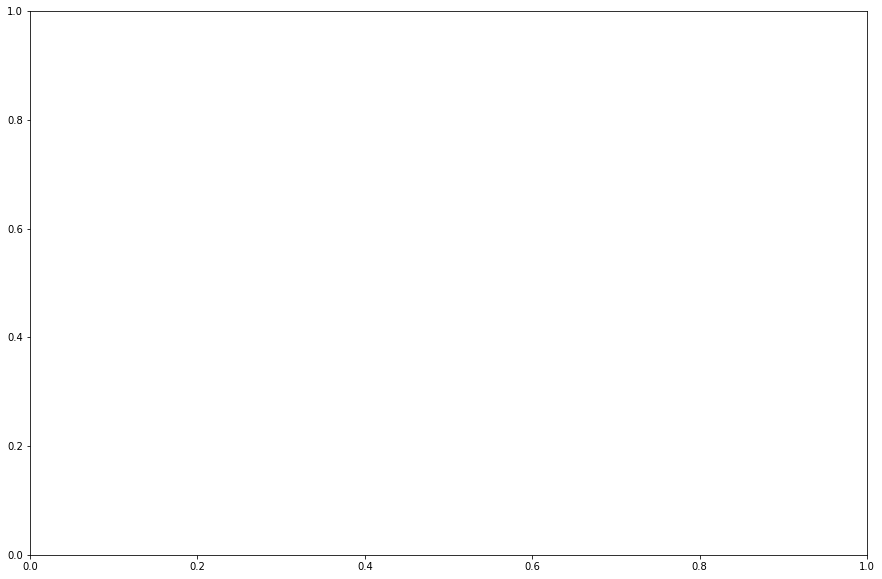

In [4]:
fig, ax=plt.subplots(figsize=(15,10))

#killed enemies
df_deaths_enemy = df.loc[df["Event"].str.contains("killed an enemy", case = False)]
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='black')


print(f"enemies killed", len(df_deaths_enemy["GameTime"]))

# player hp
df_hp = df.loc[df["Event"].str.contains("hp", case = False)]
hp = np.array([int(ev.replace("hp ","")) for ev in df_hp["Event"]])
hp_max = np.max(hp)
hp = hp/hp_max
ax.plot(df_hp["GameTime"], hp, label="hp", linewidth=4.0, color='orange')

# player armor
df_hp = df.loc[df["Event"].str.contains("armor", case = False)]
df_hp = df_hp.loc[~df_hp["Event"].str.contains("regenerate armor", case = False)]
armor = np.array([int(ev.replace("armor ","")) for ev in df_hp["Event"]])
armor_max = np.max(armor)
#ax.plot(df_hp["GameTime"], armor/armor_max, label="armor", linewidth=4.0, color='blue')



#ax.plot(x,y, linewidth=10.0, color='black', label="Average", zorder=2)
ax.set_ylabel(f"hp", fontsize=25)
ax.set_xlabel(f"Time", fontsize=25)

In [27]:
#player take damage
df_deaths_enemy = df.loc[df["Event"]=="shielded hit"]
for t in df_deaths_enemy["GameTime"]:
    ax.axvline(x=t, color = "blue")
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='blue')

df_deaths_enemy = df.loc[df["Event"]=="unshielded hit"]
for t in df_deaths_enemy["GameTime"]:
    ax.axvline(x=t, color = "orange")
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='orange')

df_deaths_enemy = df.loc[df["Event"]=="auto regenerate armor"]
for t in df_deaths_enemy["GameTime"]:
    ax.axvline(x=t,color = "lightblue")
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='blue')

df_deaths_enemy = df.loc[df["Event"]=="revived by ally"]
for t in df_deaths_enemy["GameTime"]:
    ax.axvline(x=t,color = "lightblue")
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='lightblue')

df_deaths_enemy = df.loc[df["Event"]=="downed"]
for t in df_deaths_enemy["GameTime"]:
    ax.axvline(x=t, color = "black")
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='black')